# --------------------------
# Image Blur Implementation
# --------------------------

Tensor shape: torch.Size([3, 348, 620])
Blur time: 7.16ms


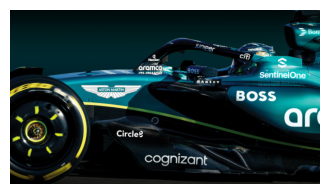

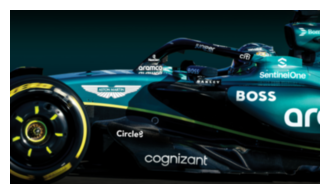

In [ ]:
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = "9.0"
import sys
sys.path.insert(0, '../..')
import torch
from utils import load_cuda, cuda_begin, show_img
import re
import time
import requests
from PIL import Image
import io
import torchvision.transforms as transforms

def get_sig(fname, src):
    res = re.findall(rf'^(.+\s+{fname}\(.*?\))\s*{{?\s*$', src, re.MULTILINE)
    return res[0]+';' if res else None

blur_cuda_src = cuda_begin + r'''
#include <cuda_runtime.h>

__device__ int clamp(int val, int min_val, int max_val) {
    return max(min_val, min(val, max_val - 1));
}

__global__ void blur_kernel(
    const float* __restrict__ input,
    float* __restrict__ output,
    int width,
    int height,
    int channels
) {
    const int x = blockIdx.x * blockDim.x + threadIdx.x;
    const int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    if (x >= width || y >= height) return;

    float sum[3] = {0.0f, 0.0f, 0.0f};
    int count = 0;

    // 3x3 blur window
    for(int dy = -1; dy <= 1; dy++) {
        for(int dx = -1; dx <= 1; dx++) {
            const int nx = clamp(x + dx, 0, width);
            const int ny = clamp(y + dy, 0, height);
            
            const float* pixel = &input[(ny * width + nx) * channels];
            
            #pragma unroll
            for(int c = 0; c < channels; c++) {
                sum[c] += pixel[c];
            }
            count++;
        }
    }

    float* out_pixel = &output[(y * width + x) * channels];
    #pragma unroll
    for(int c = 0; c < channels; c++) {
        out_pixel[c] = sum[c] / count;
    }
}

torch::Tensor blur(torch::Tensor input) {
    CHECK_INPUT(input);
    TORCH_CHECK(input.dim() == 3, "Input must be HxWxC tensor");
    
    const int height = input.size(0);
    const int width = input.size(1);
    const int channels = input.size(2);
    
    auto output = torch::zeros_like(input);
    
    // 2D block configuration (16x16 = 256 threads)
    dim3 block(16, 16);
    dim3 grid(
        (width + block.x - 1) / block.x,
        (height + block.y - 1) / block.y
    );
    
    blur_kernel<<<grid, block>>>(
        input.data_ptr<float>(),
        output.data_ptr<float>(),
        width,
        height,
        channels
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    
    return output;
}
'''

fname_blur = 'blur'
cpp_src = get_sig(fname_blur, blur_cuda_src)
blur_module = load_cuda(blur_cuda_src, cpp_src, [fname_blur])

if __name__ == "__main__":
     
    img_url = "https://sportsbase.io/images/gpfans/copy_620x348/387042db6c512271d4e6466a0eeb895fb8b625b0.jpg"
    response = requests.get(img_url)
    response.raise_for_status()
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    to_tensor = transforms.ToTensor()
    img_tensor = to_tensor(img)
 
    print("Tensor shape:", img_tensor.shape) # Tensor shape: torch.Size([3, 348, 620])
    show_img(img_tensor)
    img_tensor = img_tensor.permute(2, 1, 0).contiguous().cuda()

    # Warmup
    for _ in range(3):
        blur_module.blur(img_tensor)
    
    start = time.time()
    blurred = blur_module.blur(img_tensor)
    torch.cuda.synchronize()
    show_img(blurred.cpu().permute(2, 1, 0).contiguous())
    print(f"Blur time: {(time.time()-start)*1000:.2f}ms")